# Run an update to the masks of COGs on s3  

Paul Montesano, PhD  

Apply a single value from a `mask_fn` to a `src_fn` and write out as a COG.  

Used to post-process data for which a single extra mask value needs to be applied.

In [21]:
import sys
sys.path.append('/projects/code/icesat2_boreal/lib')

import CovariateUtils
from CovariateUtils import write_cog, get_index_tile, get_shape, reader
import build_stack

# import numpy as np
# import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import geopandas as gpd
import pandas as pd
import s3fs

import rasterio
from rasterio.plot import show_hist, show

In [5]:
from mosaiclib import *

In [19]:
boreal_tiles = gpd.read_file(boreal_tile_index_path)
boreal_tiles.explore()

In [7]:
[print(var) for var in locals() if 'TINDEX_FN' in var]

ATL08_GRANULE_TINDEX_FN_DICT
ATL08_FILT_TINDEX_FN_DICT
AGB_TINDEX_FN_DICT
HT_TINDEX_FN_DICT
HLS_TINDEX_FN_DICT
SAR_TINDEX_FN_DICT
LC_TINDEX_FN_DICT
TOPO_TINDEX_FN_DICT


[None, None, None, None, None, None, None, None]

In [5]:
AGB_TINDEX_FN_DICT

{'2019_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2019/2019_fullboreal_2019lidar/AGB_tindex_master.csv',
 '2020_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2020/atl08_v6_fullboreal_min5000_90p_local/AGB_tindex_master.csv',
 '2021_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2021/2021_fullboreal_2021lidar/AGB_tindex_master.csv',
 '2022_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2022/2022_fullboreal_2022lidar/AGB_tindex_master.csv',
 '2023_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2023/2023_full_2023lidar/AGB_tindex_master.csv',
 '2020_v2.0': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v6/AGB_H30_2020/Version2_SD/AGB_tindex_master.csv'}

In [6]:
LC_TINDEX_FN_DICT

{'c2020orig': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/LC/LC_tindex_master.csv',
 'c2020updated': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/run_build_stack/build_stack_v2023/LC_ESA_WC_2020/LC_tindex_master.csv'}

In [20]:
z = pd.read_csv( 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/run_build_stack/build_stack_v2023/LC_ESA_WC_2020/LC_tindex_master.csv')
z.head()

,index,s3_path,local_path,file,tile_num,creation time
0,0,s3://maap-ops-workspace/montesano/dps_output/r...,/projects/my-private-bucket/dps_output/run_bui...,esa_worldcover_v100_2020_354000_cog.tif,354000,2024-01-10 09:57:35
1,1,s3://maap-ops-workspace/montesano/dps_output/r...,/projects/my-private-bucket/dps_output/run_bui...,esa_worldcover_v100_2020_382300_cog.tif,382300,2024-01-10 09:57:00
2,2,s3://maap-ops-workspace/montesano/dps_output/r...,/projects/my-private-bucket/dps_output/run_bui...,esa_worldcover_v100_2020_363400_cog.tif,363400,2024-01-10 09:56:51
3,3,s3://maap-ops-workspace/montesano/dps_output/r...,/projects/my-private-bucket/dps_output/run_bui...,esa_worldcover_v100_2020_3916_cog.tif,3916,2024-01-10 09:49:38
4,4,s3://maap-ops-workspace/montesano/dps_output/r...,/projects/my-private-bucket/dps_output/run_bui...,esa_worldcover_v100_2020_4004_cog.tif,4004,2024-01-10 09:49:22


### Get a pair of AGB and LC COGs for a focal tile to test

In [9]:
def get_fn_pairs_list(tindex_src_fn, tindex_mask_fn, FOCAL_TILE=None):
    
    list_fn_pairs = []
    tindex_src = pd.read_csv(tindex_src_fn)
    tindex_mask = pd.read_csv(tindex_mask_fn)
    
    if FOCAL_TILE is not None:
        TILE_LIST = [FOCAL_TILE]
    else:
        TILE_LIST = tindex_src.tile_num.to_list()
        
    for FOCAL_TILE in TILE_LIST:
        src_fn = tindex_src[tindex_src.tile_num == FOCAL_TILE].s3_path.to_list()[0]
        mask_fn = tindex_mask[tindex_mask.tile_num == FOCAL_TILE].s3_path.to_list()[0]
        list_fn_pairs.append((src_fn, mask_fn))
    
    return list_fn_pairs      

In [11]:
FOCAL_TILE = 3082

In [12]:
src_fn, mask_fn = get_fn_pairs_list(AGB_TINDEX_FN_DICT['2020_v2.0'], LC_TINDEX_FN_DICT['c2020updated'], FOCAL_TILE=FOCAL_TILE)[0]

In [13]:
src_fn

's3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_map/boreal_agb_2024_v6/AGB_H30_2020/Version2_SD/2024/07/17/13/23/04/869479/boreal_agb_202407171721247672_003082.tif'

In [14]:
mask_fn

's3://maap-ops-workspace/montesano/dps_output/run_build_stack/build_stack_v2023/LC_ESA_WC_2020/2023/12/07/06/29/54/404821/esa_worldcover_v100_2020_3082_cog.tif'

In [15]:
s3_anon = s3 = s3fs.S3FileSystem(anon=True)
DIR_LOCAL = '/projects/my-public-bucket/local_output/mask_cogs'

In [12]:
s3_anon.download(src_fn, DIR_LOCAL)
s3_anon.download(mask_fn, DIR_LOCAL)

[None]

### Update the mask of the AGB COG for the focal tile

In [37]:
out_cog_fn = build_stack.mask_cog([os.path.join(DIR_LOCAL, os.path.basename(src_fn)), os.path.join(DIR_LOCAL, os.path.basename(mask_fn))], mask_val_list=[60])

\mask_arr shape: (3000, 3000)
Shape of input:			 (2, 3000, 3000)
Resampling:			 0	[0=nearest, 1=blinear, 2=cubic]
Output resolution:		 (30, 30)
Writing img to memory...
Current stack shape:		(2,3000,3000)


/projects/code/icesat2_boreal/lib/build_stack.py:157: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  write_cog(
Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/6b7f4e3a-a7ff-48e9-af19-c14ab6cfca78/6b7f4e3a-a7ff-48e9-af19-c14ab6cfca78.tif)' mode='r'>

Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-public-bucket/local_output/mask_cogs/boreal_agb_202407171721247672_003082_masked.tif


Image written to disk:		 /projects/my-public-bucket/local_output/mask_cogs/boreal_agb_202407171721247672_003082_masked.tif


### Check the difference between the original and updated

In [38]:
diff_cog = build_stack.diff_cogs(os.path.join(DIR_LOCAL, os.path.basename(src_fn)), out_cog_fn, FOCAL_TILE, DIR_LOCAL, diff_id_name='diff_masked', bnum=1, ndv=-9999, units='mg_ha')

Opening /projects/my-public-bucket/local_output/mask_cogs/boreal_agb_202407171721247672_003082.tif
no data value is nan
Opening /projects/my-public-bucket/local_output/mask_cogs/boreal_agb_202407171721247672_003082_masked.tif
no data value is None
Shape of input:			 (1, 3000, 3000)
Resampling:			 0	[0=nearest, 1=blinear, 2=cubic]
Output resolution:		 (30, 30)
Writing img to memory...
Current stack shape:		(1,3000,3000)


/projects/code/icesat2_boreal/lib/build_stack.py:207: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  write_cog(
Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/f2aa8531-c62e-48a1-bb89-a046641edc85/f2aa8531-c62e-48a1-bb89-a046641edc85.tif)' mode='r'>

Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-public-bucket/local_output/mask_cogs/diff_masked_0003082.tif


Image written to disk:		 /projects/my-public-bucket/local_output/mask_cogs/diff_masked_0003082.tif


### Plot

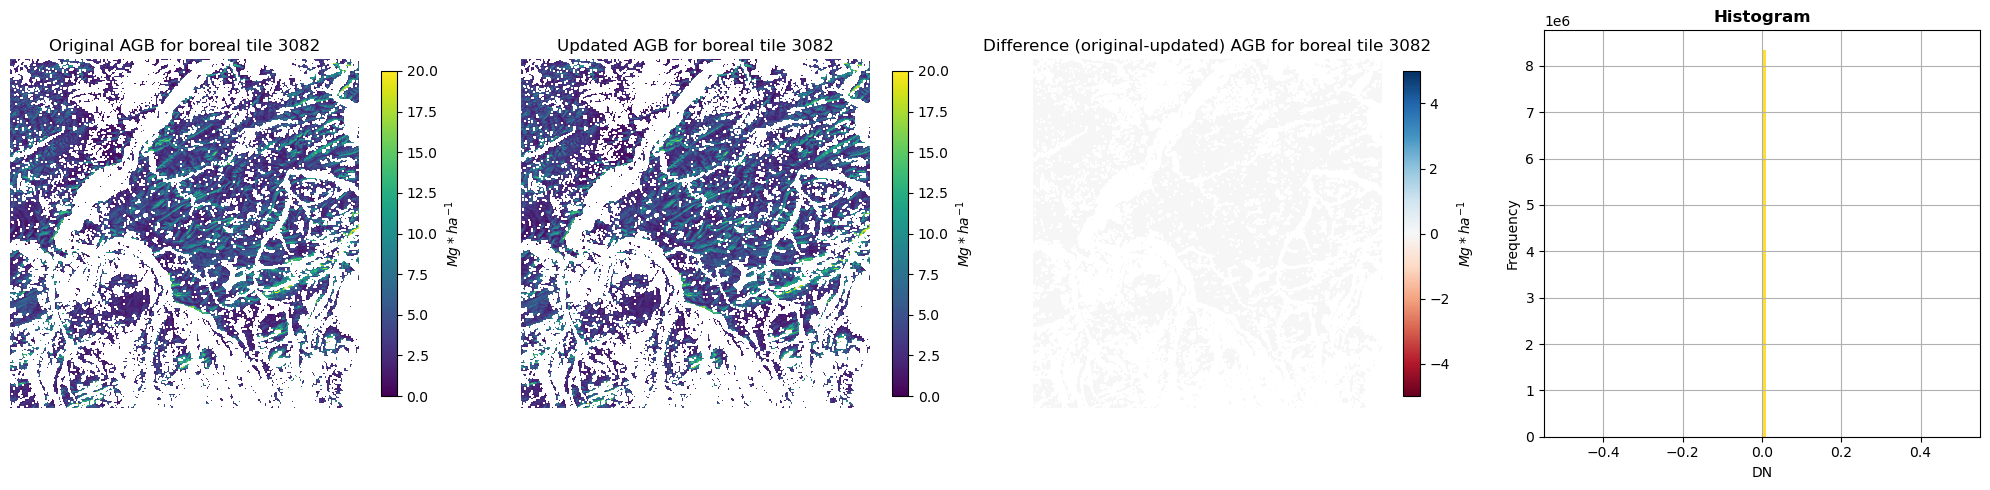

In [57]:
raster_paths = [os.path.join(DIR_LOCAL, os.path.basename(src_fn)), out_cog_fn, diff_cog]  # Replace with your file paths
raster_names = ['Original', 'Updated','Difference (original-updated)']
CMAP_LIST = ['viridis','viridis','RdBu']
CLIM_LIST = [(0,20),(0,20),(-5,5)]

# Create a figure with subplots
fig, axes = plt.subplots(1, len(raster_paths)+1, figsize=(20, 5))

# If there's only one raster, ensure axes is iterable
if len(raster_paths) == 1:
    axes = [axes]

# Loop through each raster and plot it
for i, raster_path in enumerate(raster_paths):
    VMIN, VMAX = CLIM_LIST[i]
    CMAP = CMAP_LIST[i]
    with rasterio.open(raster_path) as src:
        # Read the first band
        arr = src.read(1)
        ax = axes[i]
        image_hidden = ax.imshow(arr, cmap=CMAP, vmax=VMAX, vmin=VMIN)
        ax.imshow(arr, cmap=CMAP, vmax=VMAX, vmin=VMIN)

        # add colorbar using the now hidden image
        cbar = fig.colorbar(image_hidden, ax=ax, shrink=0.8)
        cbar.set_label('$Mg*ha^{-1}$', rotation=90)
        
        # Add title to each subplot
        ax.set_title(f'{raster_names[i]} AGB for boreal tile {FOCAL_TILE}')
        
        # Remove axis ticks
        ax.axis('off')
        
with rasterio.open(diff_cog) as ds:
    rasterio.plot.show_hist(ds.read()[0], ax=axes[-1], bins=100, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.8)
    axes[-1].get_legend().remove()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [36]:
import rioxarray as rxa
import math

In [37]:
rds_orig = rxa.open_rasterio(src_fn, masked=True)
valid_px_count = int(rds_orig.count().compute())
total_px_count = rds_orig.size
nodata_px_count_rds_orig = total_px_count - valid_px_count
nodata_px_count_rds_orig

1244370

In [38]:
rds_updated = rxa.open_rasterio(out_cog_fn, masked=True)
valid_px_count = int(rds_updated.count().compute())
total_px_count = rds_updated.size
nodata_px_count_rds_updated = total_px_count - valid_px_count
nodata_px_count_rds_updated

1301454

In [39]:
new_cnt_per_band = int((nodata_px_count_rds_updated-nodata_px_count_rds_orig) / rds_orig.shape[0])

print(f'Tile update masked an additional {new_cnt_per_band} pixels ({round(new_cnt_per_band/total_px_count*100, 2)}%)')

Tile update masked an additional 28542 pixels (0.16%)


# Multiprocess the mask update to AGB and Height COGs on s3 

[1] Test:
    - apply this mask as a multiprocess with a write to `my-private-bucket` from within a workspace owned by Laura
         - with overwrite=False
         - with overwrite=True
         - 

In [1]:
from multiprocessing import Pool
from functools import partial

In [16]:
list_of_fn_pairs = [(os.path.join(DIR_LOCAL, os.path.basename(src_fn)), os.path.join(DIR_LOCAL, os.path.basename(mask_fn)))]
list_of_fn_pairs

[('/projects/my-public-bucket/local_output/mask_cogs/boreal_agb_202407171721247672_003082.tif',
  '/projects/my-public-bucket/local_output/mask_cogs/esa_worldcover_v100_2020_3082_cog.tif')]

In [18]:
list_of_fn_pairs = get_fn_pairs_list('/projects/shared-buckets/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v1/AGB_L30_2020/filter_swap_test/AGB_tindex_master.csv',
                                     LC_TINDEX_FN_DICT['c2020updated'], 
                                     FOCAL_TILE=727)
list_of_fn_pairs

[('s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_map/boreal_agb_2024_v1/AGB_L30_2020/filter_swap_test/2024/02/12/14/05/55/385556/boreal_agb_202402121707773343_0727.tif',
  's3://maap-ops-workspace/montesano/dps_output/run_build_stack/build_stack_v2023/LC_ESA_WC_2020/2023/12/07/06/41/18/783639/esa_worldcover_v100_2020_727_cog.tif')]

In [63]:
with Pool(processes=4) as pool:
    returned_stuff = pool.map(partial(build_stack.mask_cog, mask_val_list=[60], overwrite=False ), list_of_fn_pairs)

\mask_arr shape: (3000, 3000)
Shape of input:			 (2, 3000, 3000)
Resampling:			 0	[0=nearest, 1=blinear, 2=cubic]
Output resolution:		 (30, 30)
Writing img to memory...


/projects/code/icesat2_boreal/lib/build_stack.py:157: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  write_cog(


Current stack shape:		(2,3000,3000)


Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/f1832664-2d20-472b-894f-fdf4e079644f/f1832664-2d20-472b-894f-fdf4e079644f.tif)' mode='r'>

Adding overviews...
Updating dataset tags...
Writing output to: s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_map/boreal_agb_2024_v1/AGB_L30_2020/filter_swap_test/2024/02/12/14/05/55/385556/boreal_agb_202402121707773343_0727_masked.tif


CPLE_OpenFailedError: Attempt to create new tiff file 's3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_map/boreal_agb_2024_v1/AGB_L30_2020/filter_swap_test/2024/02/12/14/05/55/385556/boreal_agb_202402121707773343_0727_masked.tif' failed: No such file or directory